___


Project: `Automatic Product Recommender (APR)`

Programmer: `@crispengari`

Date: `2022-05-10`

Abstract: `Automatic Product Recommender (APR) is a very useful topic in morden technologies. In this notebook we are going to create an Artificial Neural Network model using Deep Learning to detect weather the product is recommended or not based on review text and review upvotes. This model will be able to predict the rating of the product based on the features. APR is very usefull in moden technology because it helps product consumers to chose weather they should buy the product or not based on previous experinece customer reviews.`

Keywords: `tensorflow`, `embedding`, `keras`, `pandas`, `CNN`, `dataset`, `accuracy`, `nltk`, `loss`

Programming Language: `python`

Main: `Natural Language Processing (NLP)`

Main Package: `Tensorflow 2.*.*`

Dataset: [`kaggle`](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

____

### Automatic Product Recommender (APR)

In this notebook we are going to create a tensorflow model based on the keras subclassing api that will be able to predict two class labels:

1. rating - predict the ratting based on upvotes of the review text and the review text.
2. recommend - a binary label `0` or `1`, `1` if the product is recommended and `0` otherwise.

Our model will have two inputs which are:

1. review text
2. upvotes

### Dataset

The dataset that we are using was taken from [kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews). We are going to used the cleaned version of the dataset that was prepared in [this notebook](https://github.com/CrispenGari/APR-dl/blob/main/notebooks/00_E_Commerce_Clothing_Reviews_Data_Prep.ipynb).


### Basic imports

In the following code cell we are going to import all the packages that we are going to use in this notebook. We are also going to download some other files using `nltk`.

In [1]:

import os
import time
import random
import math
import nltk
import json

import numpy as np
import tensorflow as tf
import pandas as pd

from prettytable import PrettyTable
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from collections import Counter
from tensorflow import keras
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from google.colab import files, drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

nltk.download("punkt")

tf.__version__, keras.__version__

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


('2.8.0', '2.8.0')

### Mounting the drive
In the following code cell we are going to mount the drive since we are loading the dataset from the google drive.

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


### Seed
We are going to set seed for reproducivity in the following code cell

In [3]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

### GPU Acceleration

We are going to make use of `GPU` if available so that we can increase the speed of mathematical computations in this notebook.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
else:
  print("No GPU's")

1 Physical GPUs, 1 Logical GPUs


### Data Path
In the following code cell we are going to define where our datafile path is. Note that this file is nothing but a `csv` file that is stored in my google drive.

In [5]:
data_path = "/content/drive/My Drive/NLP Data/E-Commerce Reviews/clean_data.csv"

assert os.path.exists(data_path) == True, "File not found"

### Dataframe
We are going to read the data_path as a dataframe using `pandas` in the following code cell.

In [6]:
dataframe = pd.read_csv(data_path)
dataframe.head(4)

,Unnamed: 0,text,upvotes,recommended,rating
0,0,I had such high for this dress and really it t...,0,0,3
1,1,I love love love this it is fun flirty and fab...,0,1,5
2,2,This shirt is very flattering to all due to th...,6,1,5
3,3,I love reese but this one is not for the very ...,4,0,2


### Splitting into subsets
In the following code cell we are going to split our dataset into 3 sets:

1. training
2. testing
3. validation

In [7]:
train_df, test_df= train_test_split(dataframe, random_state=SEED, test_size=.1)
test_df, val_df = train_test_split(test_df, random_state=SEED, test_size=.3)

### Counting examples

In the following code cell we are going to count how many example belongs to each set and visualize them inform of a table.

In [8]:
def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [9]:
tabulate([
    "Set", "Total"
],[
   ("training", len(train_df)),
    ("testing", len(test_df)),
    ("validation", len(val_df)),
], "Counting examples in the dataset.")

+--------------------------------+
| Counting examples in the dataset. |
+--------------------+-----------+
| Set                |     Total |
+--------------------+-----------+
| training           |     17695 |
| testing            |      1376 |
| validation         |       591 |
+--------------------+-----------+


### Features and Lables
We have 2 features and 2 labels in our case. We are going to do some kind of preprocessing for these features and labels. First let's store all the values of features and labels in numpy arrays.

In [10]:
# Training
train_text = train_df.text.values
train_up_votes = train_df.upvotes.values
train_ratings = train_df.rating.values
train_recommends = train_df.recommended.values

# Validation
val_text = val_df.text.values
val_up_votes = val_df.upvotes.values
val_ratings = val_df.rating.values
val_recommends = val_df.recommended.values

# Testing
test_text = test_df.text.values
test_up_votes = test_df.upvotes.values
test_ratings = test_df.rating.values
test_recommends = test_df.recommended.values

### Labels processing

We are going to start by processing the labels. The labels are proccessed differently because we are doing both a binary classification and multi-label classification so they will have different activation functions.

### Ratings

Ratings start from `1` to `5` we want them to start from `0` to `4` and then `one_hot_encode` them. So that if the class label is `1` then the following will be the `one_hot_vector` for this label:

```
[0., 1., 0., 0., 0.]
```

In [11]:
train_ratings =  np.apply_along_axis(lambda x: x-1, 0, train_ratings)
val_ratings =  np.apply_along_axis(lambda x: x-1, 0, val_ratings)
test_ratings =  np.apply_along_axis(lambda x: x-1, 0, test_ratings)

In [12]:
one_hot_encode = lambda x: np.eye(5)[x]
one_hot_encode(1)

array([0., 1., 0., 0., 0.])

In [13]:
train_ratings =  np.apply_along_axis(one_hot_encode, 0, train_ratings)
val_ratings =  np.apply_along_axis(one_hot_encode, 0, val_ratings)
test_ratings =  np.apply_along_axis(one_hot_encode, 0, test_ratings)

In [14]:
train_ratings[:5]

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

### Recomends

Recoments labels are fine we don't need to do anything on them. We can check the few examples in the train set just to see if they are numbers `0` or `1`.

In [15]:
train_recommends[:5]

array([1, 0, 1, 1, 1])

### Text
Computers does not process text directly, we need to change the text to numbers by building a vocabulary which is a word to index mapping. After that we then going to pad the sequences of numbers or trancate the sequences that are longer so that by the end all the sequences should have the same size.

In [16]:
counter = Counter()
for sent in train_text:
  counter.update(word_tokenize(sent))

Checking the most common words

In [17]:
counter.most_common(10)

[('the', 61139),
 ('i', 46609),
 ('and', 39495),
 ('it', 39461),
 ('a', 34719),
 ('is', 31462),
 ('to', 19842),
 ('this', 17271),
 ('in', 16837),
 ('not', 14744)]

### The vocabulary size
We are going to use the train words to count how many unique words are there in the `counter` objects so that we can adapt to this.

In [18]:
vocab_size = len(counter)
vocab_size

7799

In the following code cell we are going to create a tokenizer based on the vocab size that we obtained in the train data and make it adapt on our train text.

In [19]:
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words = vocab_size
)
tokenizer.fit_on_texts(train_text)

In [20]:
word_indices = tokenizer.word_index
word_indices_reversed = dict([(v, k) for (k, v) in word_indices.items()])

### Helper functions
1. `sequence_to_text`

This helper function will convert a sequence of integers to a sequence of text.

2. `text_to_sequence`

This helper function will convert the sequence of text to sequence of integers.

In [21]:
def sequence_to_text(sequences):
    return " ".join(word_indices_reversed[i] for i in sequences)
    
def text_to_sequence(sent):
  words = word_tokenize(sent.lower())
  sequences = []
  for word in words:
    try:
      sequences.append(word_indices[word])
    except:
      sequences.append(0)
  return sequences

### Creating sequences

We are then going to create sequences for all our 3 sets for the text in the following code cell.

In [22]:
train_sequence_tokens = tokenizer.texts_to_sequences(train_text)
test_sequence_tokens = tokenizer.texts_to_sequences(test_text)
val_sequence_tokens = tokenizer.texts_to_sequences(val_text)

In [23]:
sequence_to_text(train_sequence_tokens[1])

'just piping in here ordered my usual size of small petite the slip that came with the dress is about a size negative zero it could hardly squeeze over my body and the dress itself is a bright pale aqua and it is a shift and because of the smocking it very strangely i think it very cheap and is ill fitting i would say if you are a person on which shift look awesome you might like this but mind the size of the slip in the range and also it is aqua'

In [24]:
sequence_to_text(test_sequence_tokens[1])

'i like the light fabric and embroidery on a otherwise hard look bomber feminine can be worn casually with jeans and a t shirt or over a dress lovely on every note fit i ordered the p and had tried on regular in store tried on the first and kept it did not try on p since the fit is loose bomber on me i like it a little more fitted there is enough room for a sweater i am in waist arms were not too snug either'

In [25]:
sequence_to_text(val_sequence_tokens[1])

"i into retailer today to buy for a later i out with this dress and another ugh it is so beautiful in person it ever so slightly out and it definitely that s feel i got it in white and plan on wearing it for my rehearsal dinner with tan and a flower crown for reference ' got some and and i got a medium would have gotten the small but it was slightly shorter"

Having a closer look on these sequences they have different lenghts of which they must be padded or truncated so that they will have the same sequence length.This is done in the following code cell.

In [26]:
max_words = 100
train_tokens_sequence_padded = keras.preprocessing.sequence.pad_sequences(
                                       train_sequence_tokens,
                                       maxlen=max_words,
                                       padding="post", 
                                       truncating="post"
                                       )
test_tokens_sequence_padded = keras.preprocessing.sequence.pad_sequences(
                                       test_sequence_tokens,
                                       maxlen=max_words,
                                       padding="post", 
                                       truncating="post"
                                       )
val_tokens_sequence_padded = keras.preprocessing.sequence.pad_sequences(
                                       val_sequence_tokens,
                                       maxlen=max_words,
                                       padding="post", 
                                       truncating="post"
                                       )

### Upvotes

Upvotes is a single number so we need to process them as inputs by doing the following.

1. first of all we need to expand the dimensions using numpy
2. we need to scale our upvotes features using `MinMaxScaler` from sklearn library

In [27]:
train_up_votes = np.expand_dims(train_up_votes, 1)
test_up_votes = np.expand_dims(test_up_votes, 1)
val_up_votes = np.expand_dims(val_up_votes, 1)

In [28]:
train_up_votes[:2]

array([[0],
       [9]])

In [29]:
scaler = MinMaxScaler()
scaler.fit(train_up_votes)

MinMaxScaler()

In [30]:
train_up_votes_scaled = scaler.transform(train_up_votes)
test_up_votes_scaled = scaler.transform(test_up_votes)
val_up_votes_scaled = scaler.transform(val_up_votes)

In [31]:
val_up_votes_scaled[:5]

array([[0.        ],
       [0.04098361],
       [0.        ],
       [0.00819672],
       [0.        ]])

### Pretrained word Embeddings
We are going to load the `Glove.6B.100d` word vectors that was uploaded in the google drive as a `txt` file. These word embeddings vectors was trained on `~6B` words and are `100` dimension.

In [32]:
embedding_path = "/content/drive/MyDrive/NLP Data/glove.6B/glove.6B.100d.txt"
assert os.path.exists(embedding_path) == True, "The path does not exists"

In [33]:
embeddings_dictionary = dict()
with open(embedding_path, encoding='utf8') as glove_file:
  for line in glove_file:
    records = line.split()
    word  = records[0]
    vectors = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vectors

Next we are going to create the embedding matrix that suits our data.

In [34]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  vector = embeddings_dictionary.get(word)
  if vector is not None:
    try:
      embedding_matrix[index] = vector
    except:
      pass

### Model

We are going to create a model using the `Sub Class API` from keras.


In [35]:
class APR(keras.Model):
  def __init__(self):
    super(APR, self).__init__()
    # layers for bidirectional
    forward_layer = keras.layers.GRU(
      128, return_sequences=True, dropout=.5,
      name="gru_forward_layer"
    )
    backward_layer = keras.layers.LSTM(
      128, return_sequences=True, dropout=.5,
      go_backwards=True, name="lstm_backward_layer"
    )
    self.embedding = keras.layers.Embedding(
          vocab_size, 100, 
          input_length=max_words,
          weights=[embedding_matrix], 
          trainable=True,
          name = "embedding_layer"
    )
    self.bidirectional = keras.layers.Bidirectional(
        forward_layer,
        backward_layer = backward_layer,
        name= "bidirectional_layer"
    )
    self.gru_layer = keras.layers.GRU(
              512, return_sequences=True,
              dropout=.5,
              name= "gru_layer"
      )
    self.lstm_layer = keras.layers.LSTM(
              512, return_sequences=True,
              dropout=.5,
              name="lstm_layer"
    )
    self.fc_1 = keras.layers.Dense(512, activation="relu", name="upvote_fc1")
    self.pooling_layer = keras.layers.GlobalAveragePooling1D(
          name="average_pooling_layer"
    )
    self.concatenate_layer = keras.layers.Concatenate(name="concatenate_layer_layer")

    self.dense_1 = keras.layers.Dense(64, activation='relu', name="dense_1")
    self.dropout_1 = keras.layers.Dropout(rate= .5, name="dropout_layer_0")
    self.dense_2 = keras.layers.Dense(512, activation='relu', name="dense_2")
    self.dropout_2 =  keras.layers.Dropout(rate= .5, name="dropout_layer_1")
    self.dense_3 = keras.layers.Dense(128, activation='relu', name="dense_3")
    self.dropout_3 = keras.layers.Dropout(rate= .5, name="dropout_layer_2")
    self.rating_output = keras.layers.Dense(5, activation='softmax', name="rating_output")
    self.recommend_output = keras.layers.Dense(1, activation='sigmoid', name="recommend_output")
        
  def call(self, inputs):
    text, upvote = inputs
    # Leaning the text features
    x_1 = self.embedding(text)
    x_1 = self.bidirectional(x_1)
    x_1 = self.gru_layer(x_1)
    x_1 = self.lstm_layer(x_1)
    x_1 = self.pooling_layer(x_1)

    # Learning the upvotes
    x_2 = self.fc_1(upvote)

    # concatenation
    x = self.concatenate_layer([x_1, x_2])

    # leaning combinned features
    x = self.dense_1(self.dropout_1(x))
    x = self.dense_2(self.dropout_2(x))
    x = self.dense_3(self.dropout_3(x))

    # outputs
    rating = self.rating_output(x)
    recommend = self.recommend_output(x)
    return rating, recommend

In [36]:
apr_model = APR()
apr_model.build([(None, 100), (None, 1)])
apr_model.summary()

Model: "apr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  multiple                 779900    
                                                                 
 bidirectional_layer (Bidire  multiple                 205568    
 ctional)                                                        
                                                                 
 gru_layer (GRU)             multiple                  1182720   
                                                                 
 lstm_layer (LSTM)           multiple                  2099200   
                                                                 
 upvote_fc1 (Dense)          multiple                  1024      
                                                                 
 average_pooling_layer (Glob  multiple                 0         
 alAveragePooling1D)                                           

### Combiling the model
In the following code cell we are going to combile our model. Note that we have multiple labels which means we require 2 different activation functions. We are going to use the following loss functions:

1. `recommend_output` - `BinaryCrossentropy`
2. `rating_output` - `CategoricalCrossentropy`

For the optimizer we are going to use the `Adam` with default paramaters.

In [37]:
recommend_output_early_stoping = keras.callbacks.EarlyStopping(
    monitor='val_output_2_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)
rating_output_early_stoping = keras.callbacks.EarlyStopping(
    monitor='val_output_1_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

apr_model.compile(
    loss = {
        "output_2" : keras.losses.BinaryCrossentropy(from_logits=False),
        "output_1" : keras.losses.CategoricalCrossentropy(from_logits=False)
    },
    metrics = ['accuracy'],
    optimizer = keras.optimizers.Adam()
)

### Training the model

In the following code cell we are going to train our model.


In [38]:
BATCH_SIZE = 128
EPOCHS = 50

history = apr_model.fit(
    x = [train_tokens_sequence_padded, train_up_votes_scaled], 
    y = [train_ratings, train_recommends.astype('int32')],
    epochs = EPOCHS,
    verbose = 1,
    shuffle=True,
    batch_size= BATCH_SIZE,
    validation_data=([val_tokens_sequence_padded, val_up_votes_scaled], [val_ratings, val_recommends.astype('int32')]),
    validation_batch_size = BATCH_SIZE//2,
    callbacks =[recommend_output_early_stoping, rating_output_early_stoping]
)

Epoch 1/50
139/139 [==============================] - 50s 254ms/step - loss: 1.7192 - output_1_loss: 1.2454 - output_2_loss: 0.4738 - output_1_accuracy: 0.5430 - output_2_accuracy: 0.8142 - val_loss: 1.5222 - val_output_1_loss: 1.1237 - val_output_2_loss: 0.3986 - val_output_1_accuracy: 0.5719 - val_output_2_accuracy: 0.8325
Epoch 2/50
139/139 [==============================] - 34s 242ms/step - loss: 1.4458 - output_1_loss: 1.0831 - output_2_loss: 0.3626 - output_1_accuracy: 0.5499 - output_2_accuracy: 0.8170 - val_loss: 1.4370 - val_output_1_loss: 1.0811 - val_output_2_loss: 0.3559 - val_output_1_accuracy: 0.5719 - val_output_2_accuracy: 0.8325
Epoch 3/50
139/139 [==============================] - 34s 243ms/step - loss: 1.3218 - output_1_loss: 1.0070 - output_2_loss: 0.3148 - output_1_accuracy: 0.5791 - output_2_accuracy: 0.8328 - val_loss: 1.2036 - val_output_1_loss: 0.9438 - val_output_2_loss: 0.2597 - val_output_1_accuracy: 0.6176 - val_output_2_accuracy: 0.8816
Epoch 4/50
139/139 

### Training history visualization
In the next code cell we are going to visualize the training history of our model.

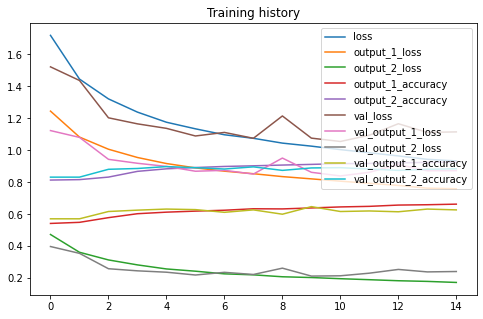

In [40]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Training history")
plt.xlabel = "Epoch(s)"
plt.ylabel = "loss/accuracy"
plt.show()


### Evaluating the Model

In the following code cell we are going to evaluate the `apr_model`.

In [41]:
apr_model.evaluate(
    x = [test_tokens_sequence_padded, test_up_votes_scaled], 
    y = [test_ratings, test_recommends.astype('int32')],
   verbose=1, batch_size=BATCH_SIZE//2
)

22/22 [==============================] - 2s 68ms/step - loss: 1.0770 - output_1_loss: 0.8466 - output_2_loss: 0.2303 - output_1_accuracy: 0.6657 - output_2_accuracy: 0.8968


[1.0769803524017334,
 0.8466321229934692,
 0.2303483635187149,
 0.6656976938247681,
 0.8968023061752319]

### Model Inference

In the following code cell we are going to create a function that will make product recommentations based on two inputs:

1. text_review
2. text_review_upvote

So the pipeline for all our features will be the same as what we did in during training.

In [42]:
def apr_predictor(text_review: str, text_review_upvote:int, model):
  recomment_classes =["NOT RECOMMENDED", "RECOMMENDED"]
  recomment_emoji = ["👎", "👍"]
  tokens = text_to_sequence(text_review)
  padded_tokens = keras.preprocessing.sequence.pad_sequences([tokens],
                                maxlen=max_words,
                                padding="post", 
                                truncating="post"
                                )
  
  text_review_upvote = scaler.transform([text_review_upvote])
  inputs = [padded_tokens, text_review_upvote]
  rating_pred, recommend_pred = model.predict(inputs)

  rating_pred = np.squeeze(rating_pred)
  rating_label = np.argmax(rating_pred)
  recomment_pred = tf.squeeze(recommend_pred).numpy()
  recomment_label = 1 if recomment_pred >=0.5 else 0
  probability = float(round(recomment_pred, 3)) if recomment_pred >= 0.5 else float(round(1 - recomment_pred, 3))

  pred_obj ={
      "recommend": {
        "label": recomment_label,
        "probability": probability,
        "class_": recomment_classes[recomment_label],
        "emoji": recomment_emoji[recomment_label]
      },
      "rating":{
          "rating": rating_label+1,
          "stars": "⭐" * (rating_label +1),
          "probability": float(round(rating_pred[rating_label], 3))
      }
  }
  return pred_obj

apr_predictor(test_text[0], test_up_votes[0], apr_model)

{'rating': {'probability': 0.46700000762939453, 'rating': 3, 'stars': '⭐⭐⭐'},
 'recommend': {'class_': 'NOT RECOMMENDED',
  'emoji': '👎',
  'label': 0,
  'probability': 0.722}}

### Saving and downloading the model.

In the following code cell we are going to download and save our model as an `.h5` static file.

In [46]:
MODEL_NAME = 'apr-model.h5'
apr_model.save_weights(MODEL_NAME)

In [47]:
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Saving and downloading the vocabulary
In the following code cell we are going to save and download the vocabulary that we used as a `json` file.


In [48]:
with open('vocab.json', 'w') as f:
  json.dump(word_indices, f)

files.download('vocab.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
len(word_indices)

7396

In [53]:
vocab_size

7799

### Saving and downloading the `train_up_votes`

We need to save and download `train_up_votes` so that we will create a `scaler` that we will use during `up_votes` preprocessing.

In [51]:
np.save('upvotes.npy', train_up_votes)
files.download('upvotes.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
train_text[0]

'I love white for summer and by august i am tired of wearing sleeveless so this caught my eye it is very easy to wear and pretty on i wore it with black tie up and super comfy stylish'

In [56]:
train_up_votes_scaled[0], train_ratings[0], train_recommends[0]

(array([0.]), array([0., 0., 0., 1., 0.]), 1)

In [58]:
train_text[1]

'Just piping in here ordered my usual size of small petite the slip that came with the dress is about a size negative zero it could hardly squeeze over my body and the dress itself is a bright pale aqua and it is a shift and because of the smocking it very strangely i think it very cheap and is ill fitting i would say if you are a person on which shift look awesome you might like this but mind the size of the slip in the range and also it is aqua'

In [59]:
train_up_votes[1], train_ratings[1], train_recommends[1]

(array([9]), array([0., 1., 0., 0., 0.]), 0)